In [1]:
# Importing NumCosmo
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())


# Importing CLMM
import clmm
from clmm import Cosmology
from clmm.support import mock_data as mock


# Importing Numpy and SciPy and time 
import numpy as np
import scipy as sp
from numpy import random
from time import perf_counter


# Importing matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams['text.latex.preamble'] = r'\usepackage{pxfonts, mathpazo}'
plt.rc('text', usetex=True)


# Importing ks R package and functions
import rpy2
from rpy2 import robjects
from rpy2.robjects.packages import importr

ks       = importr("ks")
vector   = robjects.r["as.vector"]
sphere   = robjects.r["pre.sphere"]
t        = robjects.r["t"]
Hscv     = robjects.r["Hscv"]
kde      = robjects.r["kde"]
plot_kde = robjects.r["plot"]

In [2]:
np.random.seed(1)
# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
sigma_g       = 5e-2  # True ellipticity standard variation
sigma_z       = 5e-2
ndata         = 1000
scale         = 1.0e-2

In [3]:
r_lim  = [0.4, 4.5]
z_lim  = [0.3, 4.5]
zp_lim = [0.4, 4.5]

# Create Galaxy WL Likelihood object
# gsdp  = Nc.GalaxySDPositionFlat ()
gsdp  = Nc.GalaxySDPositionSRDY1 ()
gsdzp = Nc.GalaxySDZProxyGauss ()
gsds  = Nc.GalaxySDShapeGauss ()

gsdp.set_z_lim (Ncm.Vector.new_array (z_lim))
gsdp.set_r_lim (Ncm.Vector.new_array (z_lim))
gsdzp.set_z_lim (Ncm.Vector.new_array (zp_lim))
gsdzp.set_sigma (sigma_z)
gsds.set_sigma (sigma_g)

gwll = Nc.GalaxyWLLikelihood (s_dist=gsds, zp_dist=gsdzp, rz_dist=gsdp)
gwll.set_ndata (ndata)
gwll.set_cut (cluster_z + 0.1, 2.4, 0.75, 3.0)
gwll.set_scale_cut (scale)

In [4]:
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoLCDM")
dp = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.CRITICAL, 200)
dist = Nc.Distance.new (4.0)
dist.prepare (cosmo)
smd = Nc.WLSurfaceMassDensity.new (dist)
gwll.prepare (cosmo, dp, smd, 0.4)

kde = gwll.peek_kde ()
kde_data = kde.peek_sample_array ()

kde_data_long = []
kde_data_array = []

vector = robjects.r['as.vector']

for i in range (len(kde_data)):
    for j in range (3):
        kde_data_long.append (kde_data[i].dup_array()[j])
    kde_data_array.append (kde_data[i].dup_array())

kde_data_array = np.array(kde_data_array)

kde_data_vec = vector (kde_data_long, mode="numeric")
kde_data_r   = robjects.r['matrix'](kde_data_vec, ncol=3, byrow=True)

In [5]:
h = Hscv(x=kde_data_r, pilot="unconstr")


In [6]:
print(h)

             [,1]         [,2]          [,3]
[1,]  0.079648968 1.767905e-03 -1.506350e-04
[2,]  0.001767905 1.175164e-02  9.898972e-05
[3,] -0.000150635 9.898972e-05  3.208519e-04



In [7]:
kernel = Ncm.StatsDistKernelGauss.new(3)
kde_hscv = Ncm.StatsDistKDE.new(kernel, Ncm.StatsDistCV.NONE)

for i in range(len(kde_data)):
    kde_hscv.add_obs(kde_data[i])

kde_hscv.set_cov_type(Ncm.StatsDistKDECovType.FIXED)
kde_hscv.set_cov_fixed(Ncm.Matrix.new_array([h[i] for i in range(len(h))], 3))
kde_hscv.prepare()

kde_hscv.set_over_smooth(kde_hscv.get_over_smooth() / kde_hscv.get_href())
kde_hscv.prepare()
# kde.set_cov_type(Ncm.StatsDistKDECovType.FIXED)
# kde.set_cov_fixed(Ncm.Matrix.new_array([h[i] for i in range(len(h))], 3))

kernel = Ncm.StatsDistKernelGauss.new(3)
kde_control = Ncm.StatsDistKDE.new(kernel, Ncm.StatsDistCV.NONE)

for i in range(len(kde_data)):
    kde_control.add_obs(kde_data[i])

kde_control.prepare()



kde.set_cv_type(Ncm.StatsDistCV.LOO)
kde.set_print_fit (True)
kde.prepare()

# over-smooth:                      1, amise =      -1.80193205783025
# over-smooth:       1.10517091807565, amise =      -1.78007270772112
# over-smooth:       0.90483741803596, amise =       -1.8152290871267
# over-smooth:      0.818730753077982, amise =      -1.82064727607749
# over-smooth:      0.670320046035639, amise =      -1.81056478426747
# over-smooth:      0.740818220681718, amise =      -1.81887940824043
# over-smooth:       0.90483741803596, amise =       -1.8152290871267
# over-smooth:      0.778800783071405, amise =      -1.82061976027527
# over-smooth:      0.860707976425058, amise =      -1.81887917205125
# over-smooth:      0.798516218759377, amise =      -1.82085269132947
# over-smooth:      0.778800783071405, amise =      -1.82061976027527
# over-smooth:      0.808560316321453, amise =      -1.82080542733215
# over-smooth:      0.788596890981077, amise =      -1.82079037318696
# over-smooth:      0.803522573689061, amise =      -1.82084283827101
# over-smooth:      

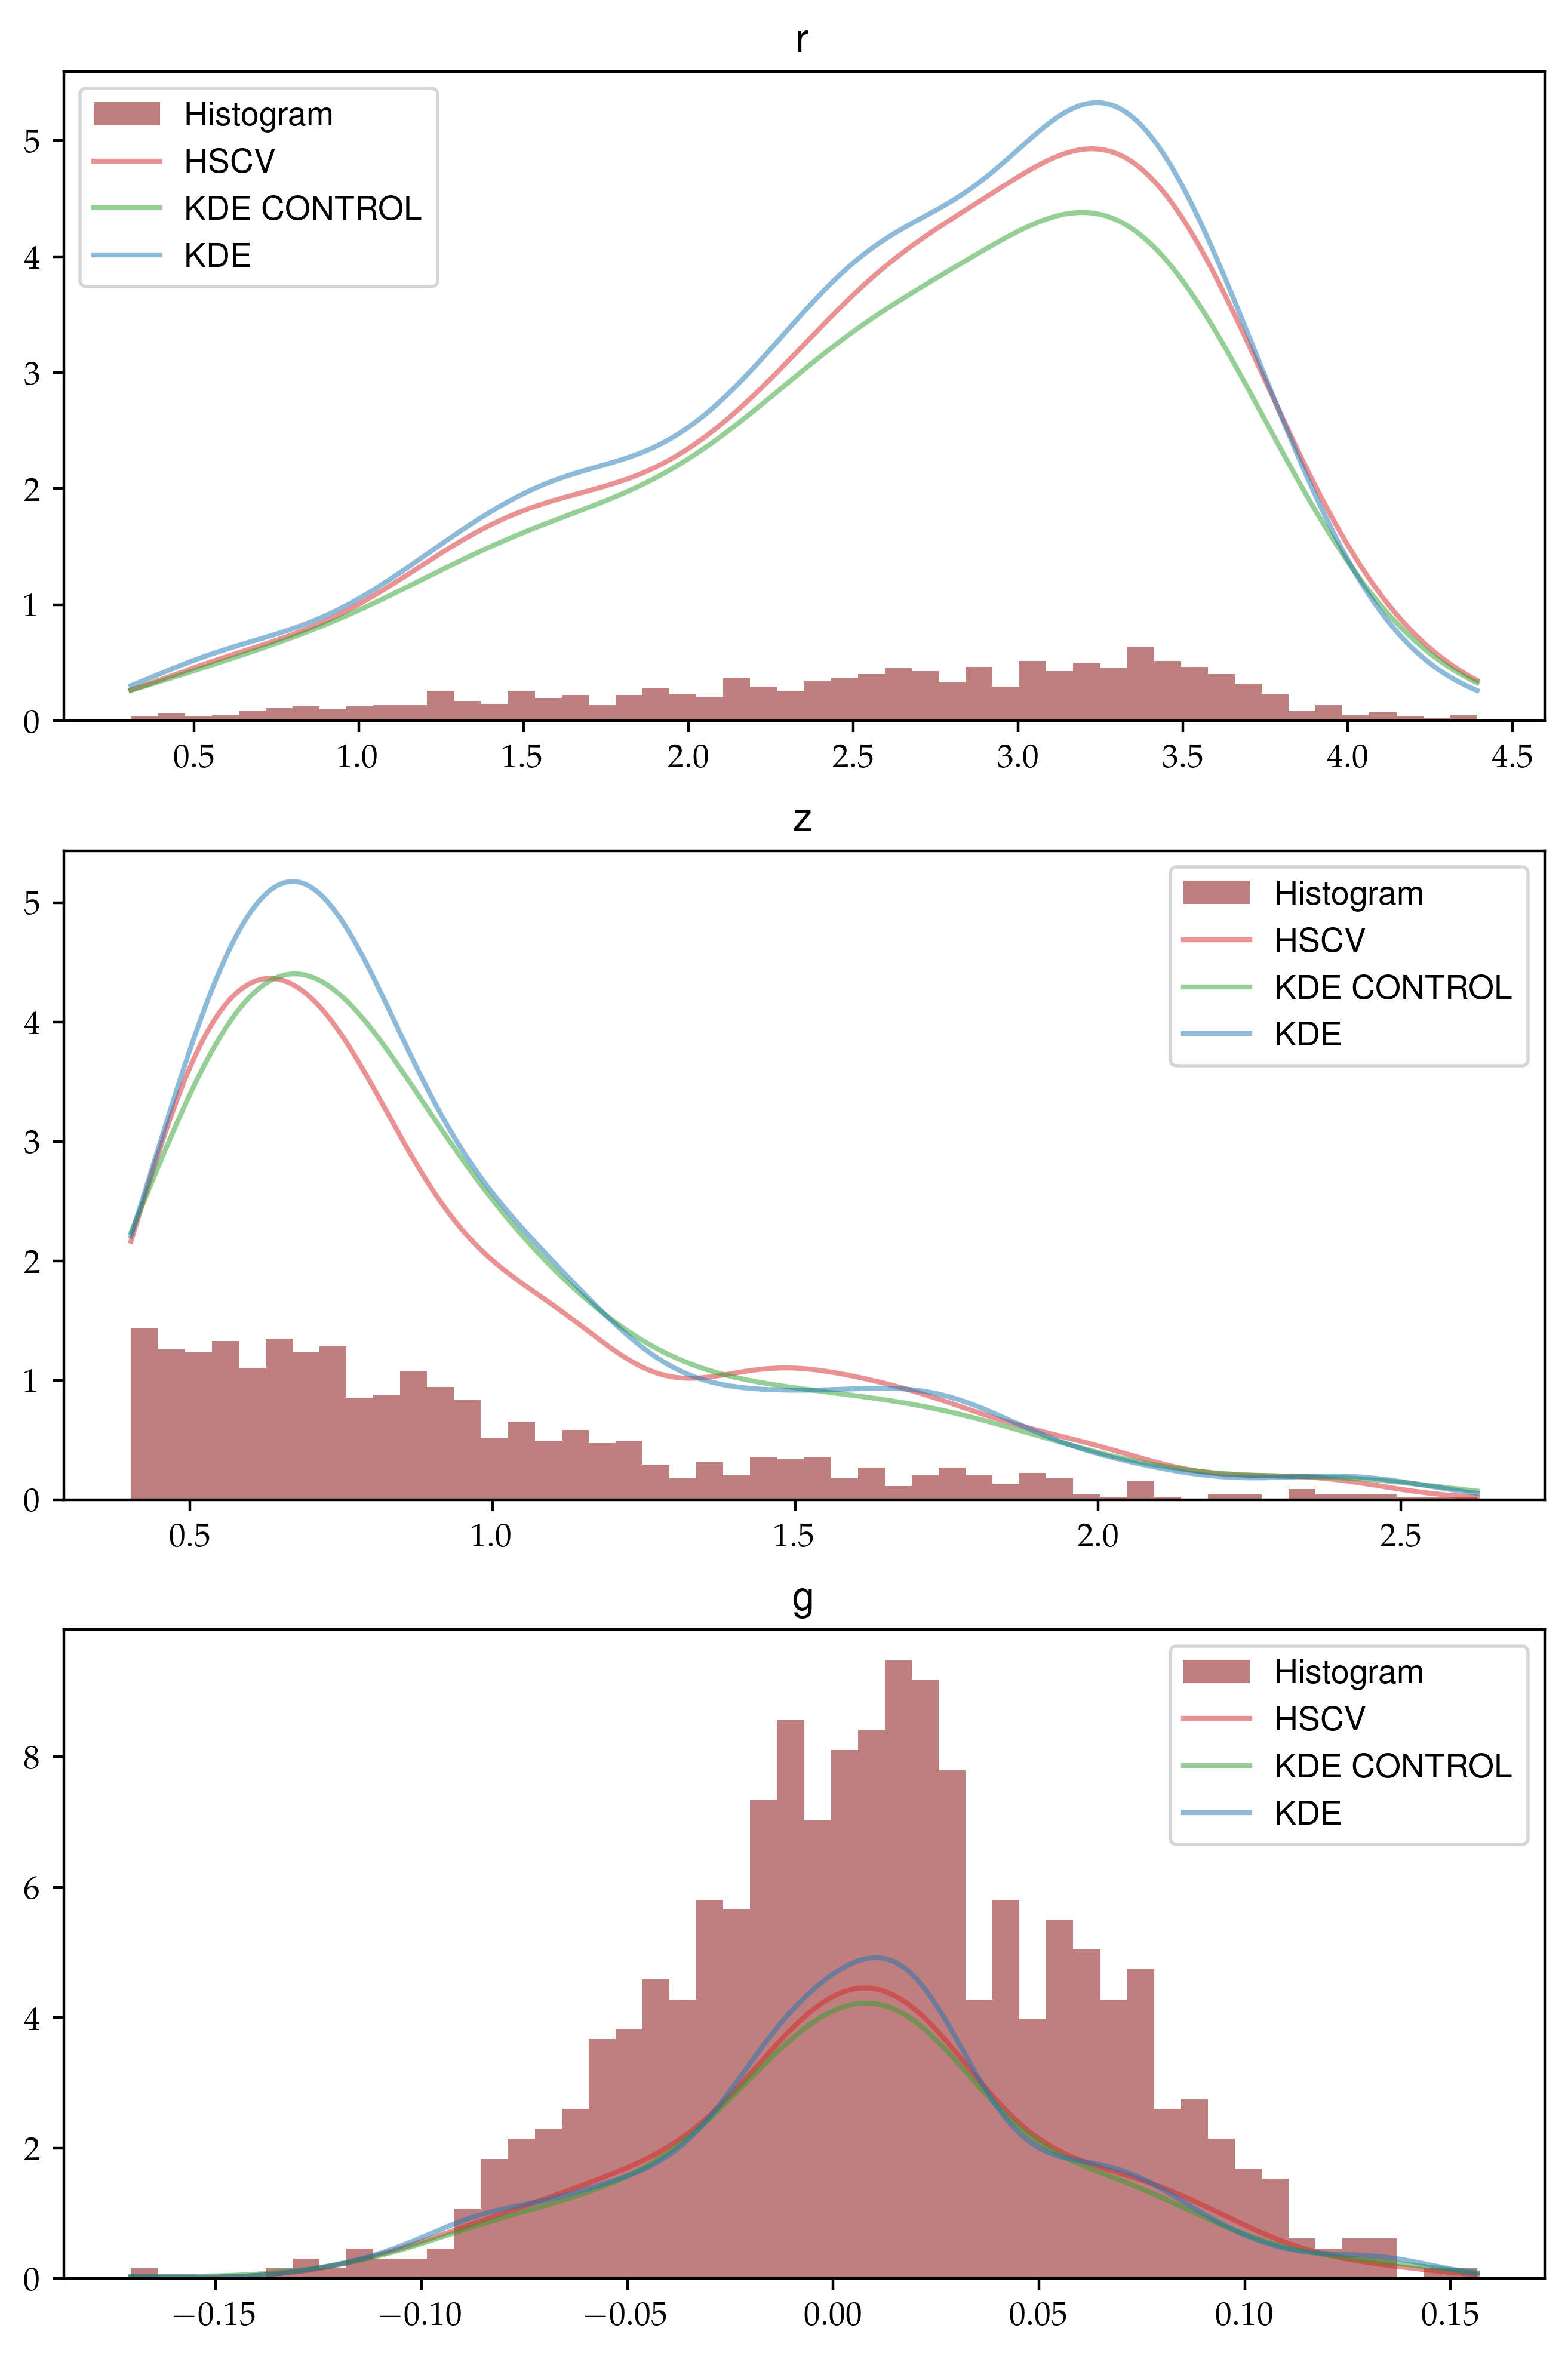

In [8]:
fig, ax = plt.subplots (3, 1, figsize=(8, 12), dpi=400, facecolor="white")

r = np.linspace(min(kde_data_array[:,0]), max(kde_data_array[:,0]), 1000)
z = np.linspace(min(kde_data_array[:,1]), max(kde_data_array[:,1]), 1000)
g = np.linspace(min(kde_data_array[:,2]), max(kde_data_array[:,2]), 1000)


# Plotting histograms
ax[0].hist(kde_data_array[:,0], bins=50, density=True, label="Histogram", alpha=0.5, color="maroon")
ax[1].hist(kde_data_array[:,1], bins=50, density=True, label="Histogram", alpha=0.5, color="maroon")
ax[2].hist(kde_data_array[:,2], bins=50, density=True, label="Histogram", alpha=0.5, color="maroon")

# Plotting KDEs
r_kde = [kde.eval(Ncm.Vector.new_array([r[i], 0.6, 0.01])) for i in range(len(r))]
z_kde = [kde.eval(Ncm.Vector.new_array([3, z[i], 0.01])) for i in range(len(z))]
g_kde = [kde.eval(Ncm.Vector.new_array([3, 0.6, g[i]])) for i in range(len(g))]

r_kde_c = [kde_control.eval(Ncm.Vector.new_array([r[i], 0.6, 0.01])) for i in range(len(r))]
z_kde_c = [kde_control.eval(Ncm.Vector.new_array([3, z[i], 0.01])) for i in range(len(z))]
g_kde_c = [kde_control.eval(Ncm.Vector.new_array([3, 0.6, g[i]])) for i in range(len(g))]

r_kde_hscv = [kde_hscv.eval(Ncm.Vector.new_array([r[i], 0.6, 0])) for i in range(len(r))]
z_kde_hscv = [kde_hscv.eval(Ncm.Vector.new_array([2.8, z[i], 0])) for i in range(len(z))]
g_kde_hscv = [kde_hscv.eval(Ncm.Vector.new_array([2.8, 0.6, g[i]])) for i in range(len(g))]

ax[0].plot(r, r_kde_hscv, label="HSCV", color="tab:red", alpha=0.5)
ax[0].plot(r, r_kde_c, label="KDE CONTROL", color="tab:green", alpha=0.5)
ax[0].plot(r, r_kde, label="KDE", color="tab:blue", alpha=0.5)

ax[1].plot(z, z_kde_hscv, label="HSCV", color="tab:red", alpha=0.5)
ax[1].plot(z, z_kde_c, label="KDE CONTROL", color="tab:green", alpha=0.5)
ax[1].plot(z, z_kde, label="KDE", color="tab:blue", alpha=0.5)

ax[2].plot(g, g_kde_hscv, label="HSCV", color="tab:red", alpha=0.5)
ax[2].plot(g, g_kde_c, label="KDE CONTROL", color="tab:green", alpha=0.5)
ax[2].plot(g, g_kde, label="KDE", color="tab:blue", alpha=0.5)

ax[0].set_title("r")
ax[1].set_title("z")
ax[2].set_title("g")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [9]:
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
moo = clmm.Modeling (massdef='mean', delta_mdef=200, halo_profile_model='nfw')
moo.set_cosmo(cosmo)
mset = moo.get_mset ()

data = mock.generate_galaxy_catalog (cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=sigma_g, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec, photoz_sigma_unscaled=sigma_z)
gc   = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
gc.compute_tangential_and_cross_components(geometry="flat")

radius = clmm.convert_units (gc.galcat['theta'], "radians", "Mpc", redshift = cluster_z, cosmo = cosmo)
r_mean = np.mean (radius)
g_mean = np.mean (gc.galcat['et'])
z_mean = np.mean (gc.galcat['z'])

r_x = np.linspace (r_lim[0], r_lim[1], 1000)
z_x = np.linspace (z_lim[0], z_lim[1], 1000)
g_x = np.linspace (min (gc.galcat['et']), max (gc.galcat['et']), 1000)

In [10]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
z_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    z_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(z):
    p_r = []
    for i in range (len(r_x)):
        x = Ncm.Vector.new_array ([r_x[i], z, g_mean])
        p_r.append (kde.eval (x))
    line.set_data(r_x, p_r)
    z_text.set_text (f'z = {z}')
    g_text.set_text (f'g = {g_mean}')
    axis.relim (); axis.autoscale_view ()
    return line, z_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = z_x, interval = 20, blit = False)
anim.save(f'r_z_control_{ndata}.mp4', writer = 'ffmpeg', fps = 30)

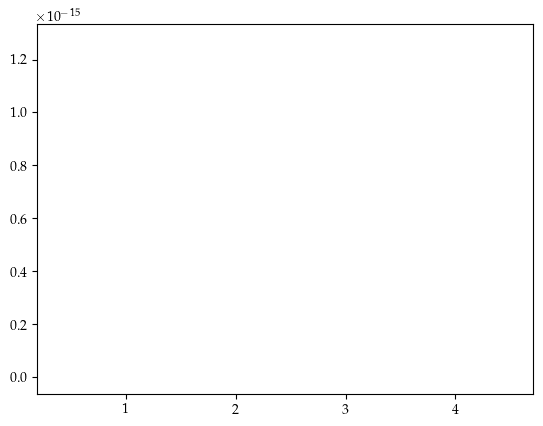

In [ ]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
z_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    z_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(g):
    p_r = []
    for i in range (len(r_x)):
        x = Ncm.Vector.new_array ([r_x[i], 0.6, g])
        p_r.append (kde.eval (x))
    line.set_data(r_x, p_r)
    z_text.set_text (f'z = {0.6}')
    g_text.set_text (f'g = {g}')
    axis.relim (); axis.autoscale_view ()
    return line, z_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = g_x, interval = 20, blit = False)
anim.save(f'r_g_control_{ndata}.mp4', writer = 'ffmpeg', fps = 30)

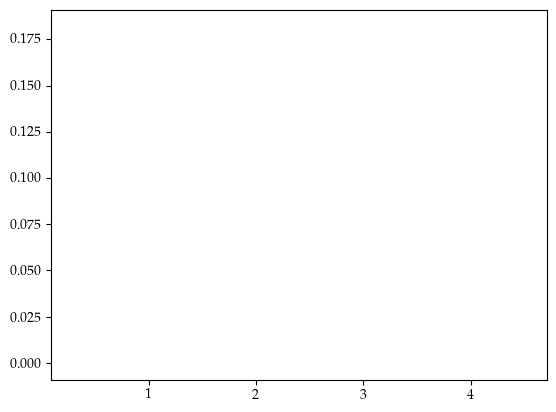

In [ ]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(r):
    p_z = []
    for i in range (len(z_x)):
        x = Ncm.Vector.new_array ([r, z_x[i], g_mean])
        p_z.append (kde.eval (x))
    line.set_data(z_x, p_z)
    r_text.set_text (f'r = {r}')
    g_text.set_text (f'g = {g_mean}')
    axis.relim (); axis.autoscale_view ()
    return line, r_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = r_x, interval = 20, blit = False)
anim.save(f'z_r_control_{ndata}.mp4', writer = 'ffmpeg', fps = 30)

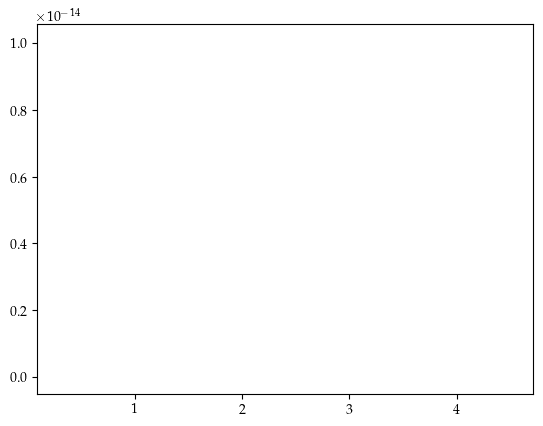

In [ ]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(g):
    p_z = []
    for i in range (len(z_x)):
        x = Ncm.Vector.new_array ([r_mean, z_x[i], g])
        p_z.append (kde.eval (x))
    line.set_data(z_x, p_z)
    r_text.set_text (f'r = {r_mean}')
    g_text.set_text (f'g = {g}')
    axis.relim (); axis.autoscale_view ()
    return line, r_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = g_x, interval = 20, blit = False)
anim.save(f'z_g_control_{ndata}.mp4', writer = 'ffmpeg', fps = 30)

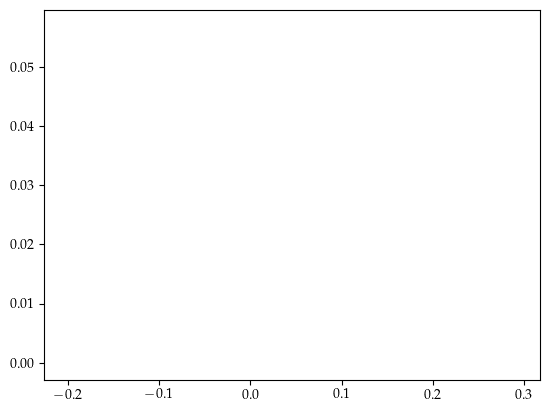

In [ ]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
z_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    z_text.set_text ('')
    return line,

def animate(r):
    p_g = []
    for i in range (len(g_x)):
        x = Ncm.Vector.new_array ([r, z_mean, g_x[i]])
        p_g.append (kde.eval (x))
    line.set_data(g_x, p_g)
    r_text.set_text (f'r = {r}')
    z_text.set_text (f'z = {z_mean}')
    axis.relim (); axis.autoscale_view ()
    return line, r_text, z_text

anim = FuncAnimation(fig, animate, init_func = init, frames = r_x, interval = 20, blit = False)
anim.save(f'g_r_control_{ndata}.mp4', writer = 'ffmpeg', fps = 30)

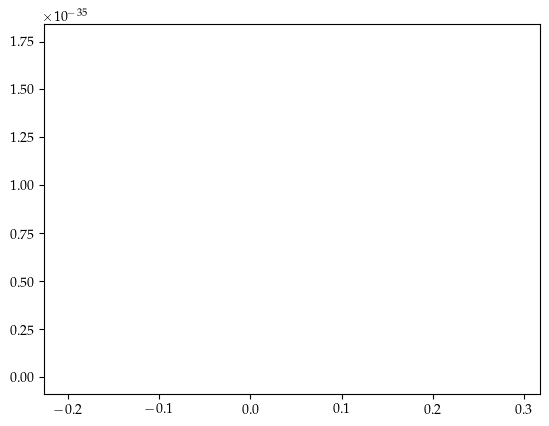

In [ ]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
z_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    z_text.set_text ('')
    return line,

def animate(z):
    p_g = []
    for i in range (len(g_x)):
        x = Ncm.Vector.new_array ([r_mean, z, g_x[i]])
        p_g.append (kde.eval (x))
    line.set_data(g_x, p_g)
    r_text.set_text (f'r = {r_mean}')
    z_text.set_text (f'z = {z}')
    axis.relim (); axis.autoscale_view ()
    return line, r_text, z_text

anim = FuncAnimation(fig, animate, init_func = init, frames = z_x, interval = 20, blit = False)
anim.save(f'g_z_control_{ndata}.mp4', writer = 'ffmpeg', fps = 30)